# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [18]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [19]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [21]:
ds_train = pd.read_csv("C:/Users/maico/Documents/Mestrado/dmeyf2023/datasets/competencia_02.csv")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [22]:
Xbajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)


Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [23]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'num_iterations': 670,
    'learning_rate': 0.0100738668153211,
    'feature_fraction': 0.413040235996875,
    'verbose': -100,
    'max_bin': 31,
    'min_data_in_leaf': 2858,
    'num_leaves:': 161,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(Xbajas)


Found `num_iterations` in params. Will use it instead of argument


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [24]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
1,foto_mes,1704
16,mcuenta_corriente,861
22,mcuentas_saldo,668
33,mprestamos_personales,660
10,mactivos_margen,549
...,...,...
47,cseguro_auto,0
62,mpagodeservicios,0
130,Master_cadelantosefectivo,0
40,mplazo_fijo_pesos,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [25]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [26]:
print()
cliente_idx = 7 # el 

In [27]:
pd.concat([Xbajas.iloc[7], shap_bajas.iloc[7]], axis=1)

,347,7
numero_de_cliente,122200794.0,0.001743
foto_mes,201905.0,-0.133862
active_quarter,1.0,-0.001400
cliente_vip,0.0,0.000000
internet,1.0,0.046058
...,...,...
Visa_fechaalta,NaN,-0.035487
Visa_mconsumototal,NaN,-0.006417
Visa_cconsumos,NaN,-0.010572
Visa_cadelantosefectivo,NaN,0.000227


Y consolidamos sus importancias

In [28]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter                   0.531851
mcaja_ahorro                   0.370113
cpayroll_trx                   0.338863
mpayroll                       0.322650
mtarjeta_visa_consumo          0.208416
                                 ...   
ccajeros_propios_descuentos    0.000000
cliente_vip                    0.000000
mcajeros_propios_descuentos    0.000000
mtarjeta_visa_descuentos       0.000000
mtarjeta_master_descuentos     0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

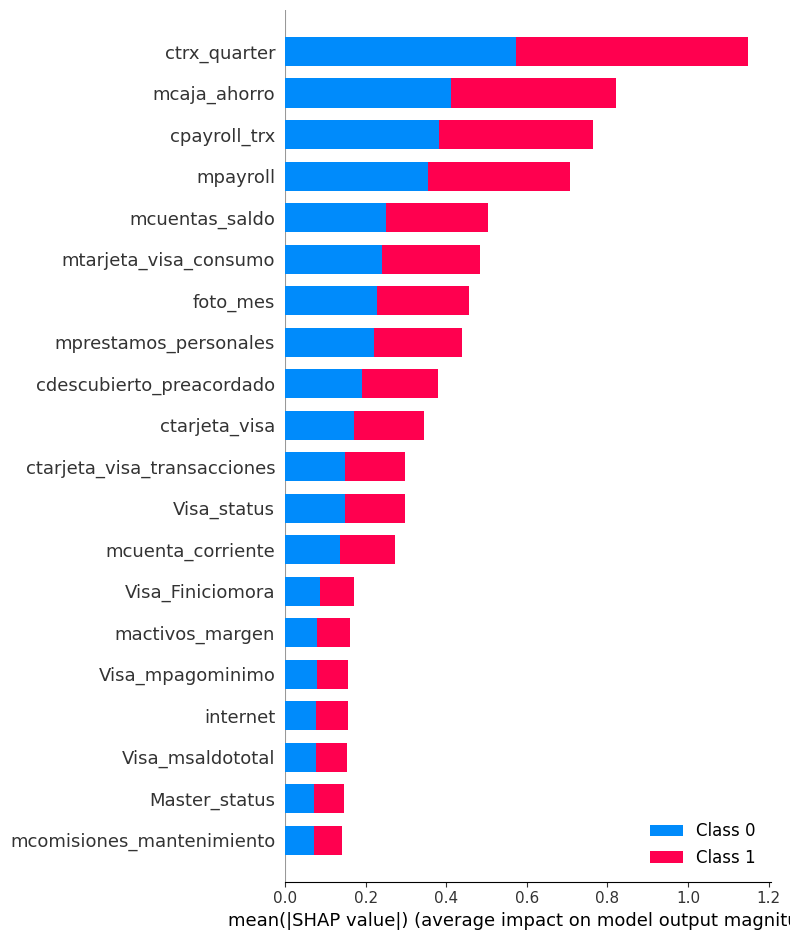

In [30]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

¿Se podrá hacer una clusterización sobre los valores de shap?

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

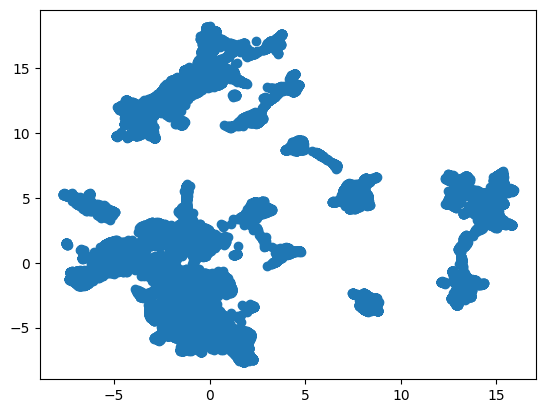

In [31]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

(array([19668.,  6182.,  3206.,  2013.,  1434.,  1225.,  1218.,  1231.,
         1267.,   823.]),
 array([2.02965588e-04, 9.34691990e-02, 1.86735432e-01, 2.80001666e-01,
        3.73267899e-01, 4.66534133e-01, 5.59800366e-01, 6.53066600e-01,
        7.46332833e-01, 8.39599066e-01, 9.32865300e-01]),
 <BarContainer object of 10 artists>)

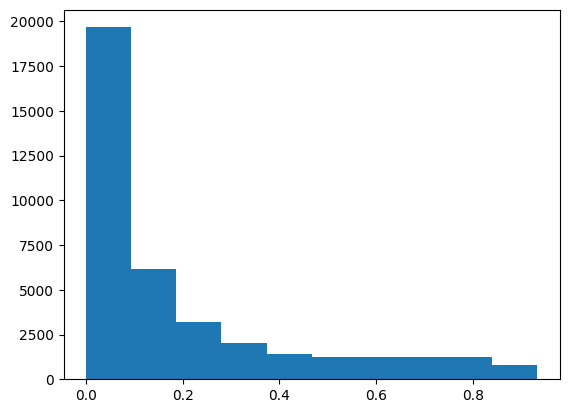

In [33]:
p_bajas = gbm.predict(Xbajas)
plt.hist(p_bajas)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

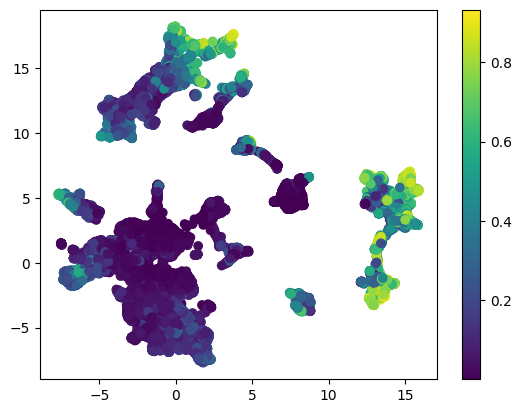

In [35]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


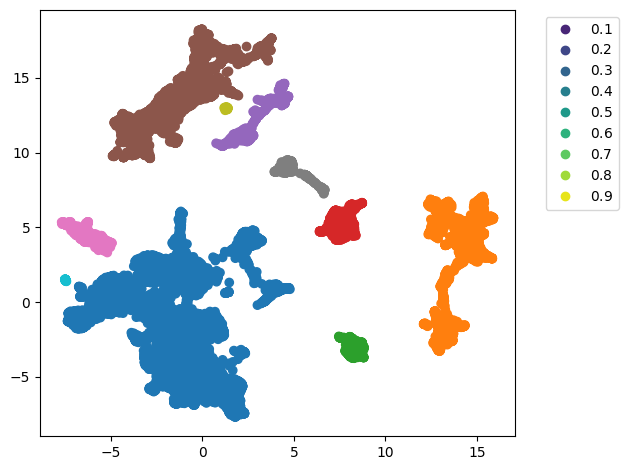

In [36]:

hdb = DBSCAN(eps=0.75)
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='tab10')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

chomebanking_transacciones    0.011027
mtransferencias_emitidas      0.006422
ctransferencias_emitidas      0.002843
thomebanking                  0.002570
mprestamos_personales         0.001994
                                ...   
cdescubierto_preacordado     -0.443352
ctrx_quarter                 -0.452666
mcaja_ahorro                 -0.497870
ctarjeta_visa                -0.538606
Visa_status                  -0.897132
Length: 154, dtype: float64

In [38]:
shap_bajas[y.labels_ == 6].mean().sort_values(ascending=False)

ctarjeta_visa                 0.028637
chomebanking_transacciones    0.020888
thomebanking                  0.011623
ccaja_ahorro                  0.011610
mtransferencias_emitidas      0.010995
                                ...   
mpayroll                     -0.385536
cpayroll_trx                 -0.427759
mcaja_ahorro                 -0.604876
cdescubierto_preacordado     -0.608595
ctrx_quarter                 -0.854634
Length: 154, dtype: float64

In [39]:
Xbajas.loc[y.labels_ == 1]["cprestamos_personales"].mean()

1.2322437449556094

In [40]:
Xbajas.loc[y.labels_ == 6]["cprestamos_personales"].mean()

0.027906976744186046

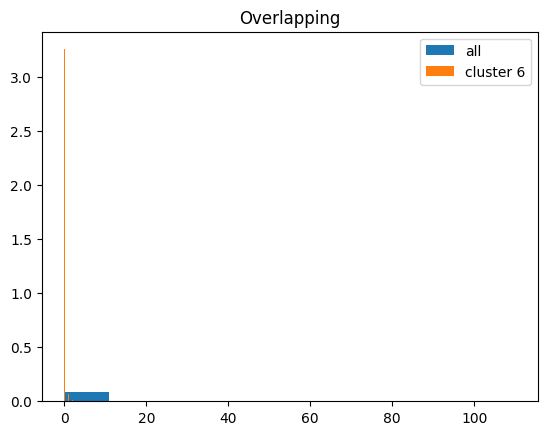

In [41]:
plt.hist(Xbajas.loc[:]["cprestamos_personales"], label='all', density=True)
plt.hist(Xbajas.loc[y.labels_ == 6]["cprestamos_personales"], label='cluster 6', density=True)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

## Random Forest distance

Armamos un conjunto de datos

In [42]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

NameError: name 'ytrain' is not defined

In [ ]:
XRF = Xtrain.iloc[rf_index]
yRF = ytrain.iloc[rf_index]

In [ ]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Umap de rf

using precomputed metric; inverse_transform will be unavailable


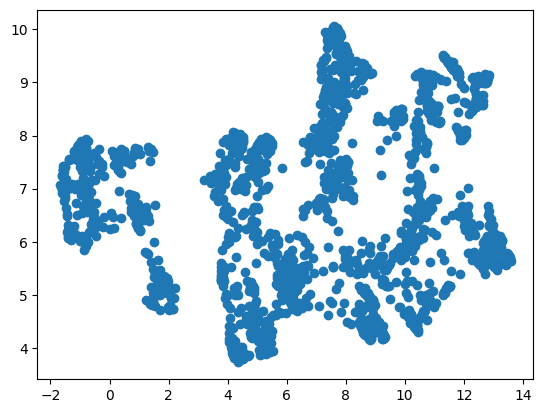

In [ ]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1])

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])